# <font color='blue'>Projeto 1 - Segmentação de Clientes de Food Delivery</font>

In [2]:
# Imports

# Manipulação e visualização de dados
import time
import sklearn
import datetime
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib as m
import matplotlib.pyplot as plt

# Machine Learning
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler

# Formatação dos gráficos
plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
%matplotlib inline

<Figure size 1500x600 with 0 Axes>

### Carregando e Compreendendo os Dados

In [3]:
df_food_delivery = pd.read_csv("data/dataset.csv", encoding='utf-8')
df_food_delivery.shape

(260645, 7)

In [4]:
df_food_delivery.head()

,id_transacao,horario_pedido,localidade,nome_item,quantidade_item,latitude,longitude
0,0x7901ee,2019-01-16 18:33:00,7,bebida,2,41.794132,-88.010140
1,0x7901ee,2019-01-16 18:33:00,7,pizza,2,41.794132,-88.010140
2,0x7901ee,2019-01-16 18:33:00,7,sobremesa,2,41.794132,-88.010140
3,0x12b47f,2019-09-04 12:36:00,3,salada,1,41.884490,-87.627059
4,0x12b47f,2019-09-04 12:36:00,3,sobremesa,1,41.884490,-87.627059


## Dicionário de Dados

Variável | Descrição
--- | ---
id_transacao | ID da transação. Um mesmo ID pode ter vários itens de um pedido.
horario_pedido | Horário exato do pedido.
localidade | Localidade que processou o pedido (unidade do restaurante).
nome_item | Nome do item (pizza, salada, bebida e sobremesa).
quantidade_item | Quantidade de itens no pedido.
latitude | Latitude da localidade onde o pedido foi gerado.
longitude | Longitude da localidade onde o pedido foi gerado.


### Análise Exploratória

In [5]:
# Verificando valores unicos por coluna
df_food_delivery.nunique()

id_transacao       100000
horario_pedido      76799
localidade              9
nome_item               4
quantidade_item         5
latitude                9
longitude               9
dtype: int64

In [6]:
# Tipos de dados
df_food_delivery.dtypes

id_transacao        object
horario_pedido      object
localidade           int64
nome_item           object
quantidade_item      int64
latitude           float64
longitude          float64
dtype: object

In [7]:
# Resumo das colunas númericas
df_food_delivery.describe()

,localidade,quantidade_item,latitude,longitude
count,260645.000000,260645.000000,260645.000000,260645.000000
mean,5.134904,2.447010,41.836095,-87.733930
std,2.551846,1.330863,0.144459,0.136369
min,1.000000,1.000000,41.524598,-88.010140
25%,3.000000,1.000000,41.784576,-87.849468
50%,5.000000,2.000000,41.881818,-87.677606
75%,7.000000,4.000000,41.889047,-87.627059
max,9.000000,5.000000,42.049306,-87.607565


### Pivot - Manual

In [8]:
# Lista para receber o total de pedidos
total_pedidos = []

In [9]:
print("\nIniciando o agrupamento para o cálculo do total de pedidos.")

# Extraindo cada id e cada grupo do 'group by' por id_transacao
for k, group in df_food_delivery.groupby('id_transacao'):
    
    # Extraindo cada id e cada grupo do group by por horario_pedido
    for m, n in group.groupby('horario_pedido'):

        # Cada item de cada grupo
        id_transacao = k
        horario_pedido = m
        localidade = n['localidade'].values.tolist()[0]
        bebida = 0
        pizza = 0
        sobremesa = 0
        salada = 0
        n = n.reset_index(drop=True)

        # Contabilizando os itens pedidos
        for i in range(len(n)):
            item = n.loc[i, 'nome_item']
            num = n.loc[i,'quantidade_item']

            if item == 'bebida':
                bebida = bebida + num

            elif item == 'pizza':
                pizza = pizza + num
            
            elif item == 'sobremesa':
                sobremesa = sobremesa + num

            elif item == 'salada':
                salada = salada + num

        output = [id_transacao, horario_pedido, localidade, bebida, pizza, sobremesa, salada]
        total_pedidos.append(output)
        
print("\nAgrupamento concluído!")



Iniciando o agrupamento para o cálculo do total de pedidos.

Agrupamento concluído!


In [10]:
# Convertendo a lista para dataframe e ajustando os nomes das colunas
df_item_pedidos = pd.DataFrame(total_pedidos)
df_item_pedidos.columns = ['id_transacao', 'horario_pedido', 'localidade', 'bebida', 'pizza', 'sobremesa', 'salada']
df_item_pedidos.shape

(100000, 7)

In [11]:
# Verificando o total de valores únicos por coluna
df_item_pedidos.nunique()

id_transacao      100000
horario_pedido     76799
localidade             9
bebida                 6
pizza                  6
sobremesa              5
salada                 6
dtype: int64

In [12]:
# Resultado do pivot
df_item_pedidos.head(10)

,id_transacao,horario_pedido,localidade,bebida,pizza,sobremesa,salada
0,0x10000a,2019-01-29 00:48:00,9,0,1,1,0
1,0x100058,2019-05-05 00:08:00,6,0,2,2,0
2,0x1000c8,2019-01-28 19:24:00,9,4,4,5,1
3,0x10014c,2019-02-23 00:15:00,6,0,1,1,0
4,0x1001d8,2019-06-30 17:50:00,2,3,3,3,0
5,0x1002af,2019-12-28 17:25:00,9,3,3,4,1
6,0x10034c,2019-03-12 18:17:00,5,3,4,4,0
7,0x100378,2019-10-13 18:44:00,4,4,4,5,1
8,0x100391,2019-10-10 18:07:00,5,4,4,4,0
9,0x1003a9,2019-06-23 00:39:00,6,0,2,2,0


### Pivot - Automático

In [13]:
df_pivot = df_food_delivery.pivot_table(index=['id_transacao'], columns=['nome_item'], values='quantidade_item')
df_pivot = df_pivot.fillna(0).reset_index()
df_pivot.columns

Index(['id_transacao', 'bebida', 'pizza', 'salada', 'sobremesa'], dtype='object', name='nome_item')

In [14]:
# Resultado
df_pivot.head()

nome_item,id_transacao,bebida,pizza,salada,sobremesa
0,0x10000a,0.0,1.0,0.0,1.0
1,0x100058,0.0,2.0,0.0,2.0
2,0x1000c8,4.0,4.0,1.0,5.0
3,0x10014c,0.0,1.0,0.0,1.0
4,0x1001d8,3.0,3.0,0.0,3.0


In [15]:
# Valroes unicos
df_pivot.nunique()

nome_item
id_transacao    100000
bebida               6
pizza                6
salada               6
sobremesa            5
dtype: int64

In [16]:
# Shape
df_pivot.shape

(100000, 5)

In [17]:
# Describe
df_pivot.describe()

nome_item,bebida,pizza,salada,sobremesa
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.239590,1.857840,0.711370,2.569210
std,1.627886,1.588589,1.086524,1.332084
min,0.000000,0.000000,0.000000,1.000000
25%,0.000000,1.000000,0.000000,1.000000
50%,0.000000,1.000000,0.000000,2.000000
75%,3.000000,3.000000,1.000000,4.000000
max,5.000000,5.000000,5.000000,5.000000


In [18]:
# Incluindo a coluna localidade
df_pivot2 = df_pivot.merge(df_food_delivery[['id_transacao', 'localidade']])
df_pivot2.head()

,id_transacao,bebida,pizza,salada,sobremesa,localidade
0,0x10000a,0.0,1.0,0.0,1.0,9
1,0x10000a,0.0,1.0,0.0,1.0,9
2,0x100058,0.0,2.0,0.0,2.0,6
3,0x100058,0.0,2.0,0.0,2.0,6
4,0x1000c8,4.0,4.0,1.0,5.0,9


In [19]:
# Shape
df_pivot2.nunique()

id_transacao    100000
bebida               6
pizza                6
salada               6
sobremesa            5
localidade           9
dtype: int64

### Extraindo Granularidade de Tempo

A coluna de horário do pedido tem detalhes como mês, dia e ano. Em algum momento pode ser interessante fazer a segmentação por mês, por exemplo.

In [20]:
# Visualizando os dados
df_item_pedidos.head(3)

,id_transacao,horario_pedido,localidade,bebida,pizza,sobremesa,salada
0,0x10000a,2019-01-29 00:48:00,9,0,1,1,0
1,0x100058,2019-05-05 00:08:00,6,0,2,2,0
2,0x1000c8,2019-01-28 19:24:00,9,4,4,5,1


In [21]:
# Extraindo o mês da coluna horario_pedido
df_item_pedidos['mes'] = df_item_pedidos['horario_pedido'].apply(lambda x: time.strftime("%m", time.strptime(x,"%Y-%m-%d %H:%M:%S")))
df_pivot = df_pivot.merge(df_item_pedidos[['id_transacao', 'mes']])
df_pivot.head(10)

,id_transacao,bebida,pizza,salada,sobremesa,mes
0,0x10000a,0.0,1.0,0.0,1.0,01
1,0x100058,0.0,2.0,0.0,2.0,05
2,0x1000c8,4.0,4.0,1.0,5.0,01
3,0x10014c,0.0,1.0,0.0,1.0,02
4,0x1001d8,3.0,3.0,0.0,3.0,06
5,0x1002af,3.0,3.0,1.0,4.0,12
6,0x10034c,3.0,4.0,0.0,4.0,03
7,0x100378,4.0,4.0,1.0,5.0,10
8,0x100391,4.0,4.0,0.0,4.0,10
9,0x1003a9,0.0,2.0,0.0,2.0,06


In [22]:
# Valores únicos
df_pivot.nunique()

id_transacao    100000
bebida               6
pizza                6
salada               6
sobremesa            5
mes                 12
dtype: int64

### Ajuste de Índices

In [23]:
# Índice
df_item_pedidos.index

RangeIndex(start=0, stop=100000, step=1)

In [24]:
# Reset no índice e gravando o resultado em outro dataframe
df_item_pedidos_idx = df_item_pedidos.reset_index()
df_item_pedidos_idx.head()

,index,id_transacao,horario_pedido,localidade,bebida,pizza,sobremesa,salada,mes
0,0,0x10000a,2019-01-29 00:48:00,9,0,1,1,0,01
1,1,0x100058,2019-05-05 00:08:00,6,0,2,2,0,05
2,2,0x1000c8,2019-01-28 19:24:00,9,4,4,5,1,01
3,3,0x10014c,2019-02-23 00:15:00,6,0,1,1,0,02
4,4,0x1001d8,2019-06-30 17:50:00,2,3,3,3,0,06


### Análise Descritiva

### Distplot dos Atributos Usados Para Segmentação

C:\Users\moise\AppData\Local\Temp\ipykernel_11212\3443832856.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_item_pedidos[x], bins = 20)
C:\Users\moise\AppData\Local\Temp\ipykernel_11212\3443832856.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_item_pedidos[x], bins = 20)
C:\Use

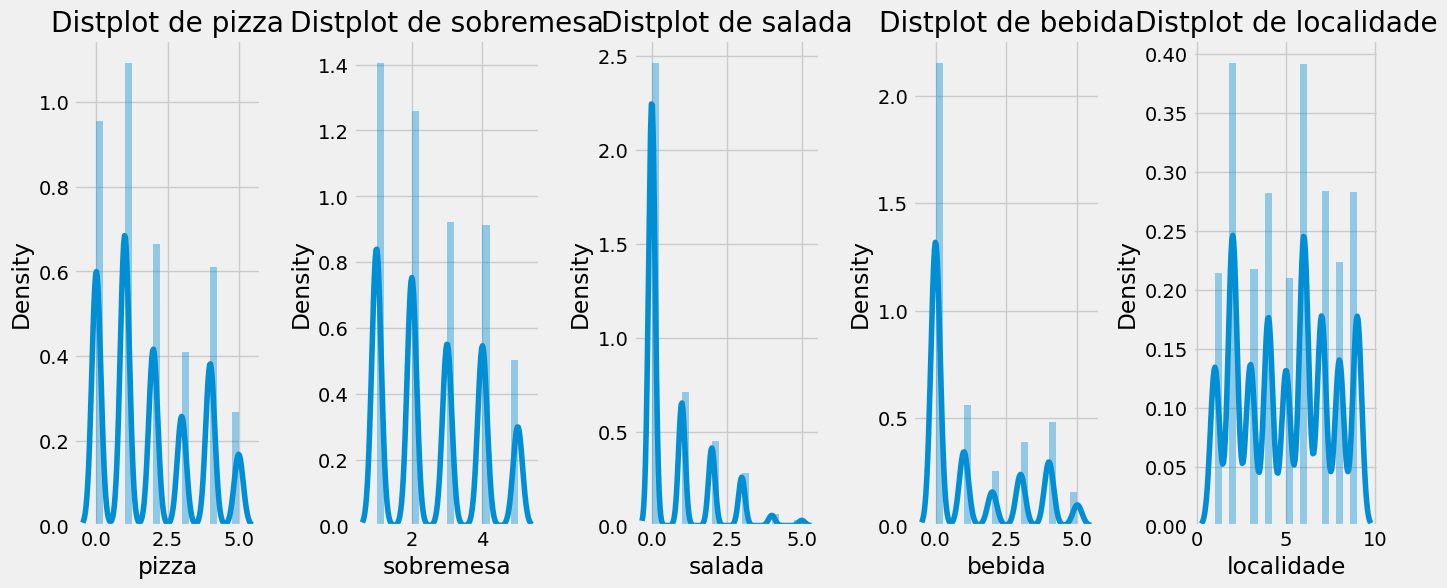

In [27]:
# Plot

plt.figure(1, figsize = (15, 6))

# Inicializa o contador
n = 0

# loop pelas colunas

for x in ['pizza' , 'sobremesa' , 'salada', 'bebida', 'localidade']:
    n += 1
    plt.subplot(1, 5, n)
    plt.subplots_adjust(hspace=0.5, wspace=0.5)
    sns.distplot(df_item_pedidos[x], bins = 20)
    plt.title('Distplot de {}'.format(x))
plt.show()

### Gráfico de Total de Pedidos Por Localidade

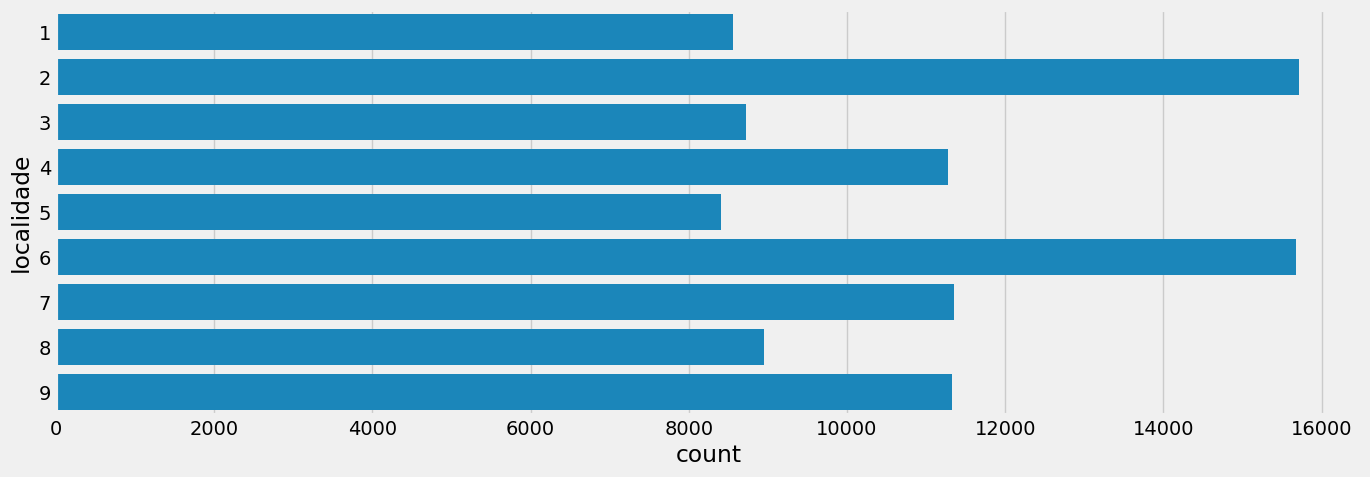

In [28]:
# Plot

plt.figure(1, figsize=(15, 5))
sns.countplot(y = 'localidade', data = df_item_pedidos)
plt.show()

### Regplot dos Atributos Usados Para Segmentação

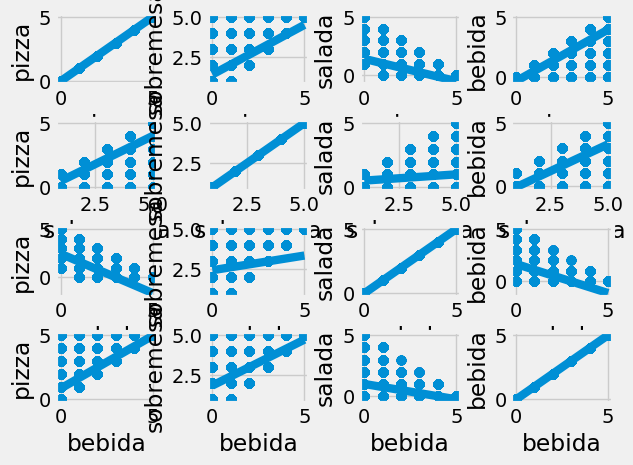

In [29]:
# Relação Entre os Atributos

# Inicializa o contador 
n = 0

# Loop pelos atributos
for x in ['pizza' , 'sobremesa' , 'salada', 'bebida']:
    for y in ['pizza' , 'sobremesa' , 'salada', 'bebida']:
        n += 1
        plt.subplot(4, 4, n)
        plt.subplots_adjust(hspace= 0.5, wspace=0.5)
        sns.regplot(x = x, y = y, data = df_item_pedidos)
        plt.ylabel(y)
plt.show()

### Definindo as Variáveis Para Segmentação

Removendo id_transacao, horario_pedido, localidade e mes para a atividade de clusterização.

In [32]:
# Filtrando o dataframe por colunas 
df = df_item_pedidos_idx[['index', 'bebida', 'pizza', 'sobremesa', 'salada']]

# Dataset
df.head()

,index,bebida,pizza,sobremesa,salada
0,0,0,1,1,0
1,1,0,2,2,0
2,2,4,4,5,1
3,3,0,1,1,0
4,4,3,3,3,0


### Análise de Cluster

Clusterização é um processo de aprendizagem não supervisionada, quando entregamos a um algoritmo de Machine Learning somente os dados de entrada e durante o treinamento, o algoritmo cria um modelo capaz de gerar saídas, nesse caso grupos, ou clusters.

![title](imagens/cluster.png)

### Algoritmo de Clusterização - K-means

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

O K-Means Clustering é um algoritmo de aprendizado de máquina não supervisionado. Em contraste com os algoritmos tradicionais de aprendizado de máquina supervisionado, o K-Means tenta classificar dados sem antes ter sido treinado com dados rotulados. Depois que o algoritmo é executado e os grupos são definidos, qualquer novo dado pode ser facilmente atribuído ao grupo mais relevante.


![title](imagens/kmeans.png)

K-Means é provavelmente o algoritmo de agrupamento mais conhecido. É fácil entender e implementar! Confira o gráfico abaixo para obter uma ilustração.

![title](imagens/k-means.gif)


- Para começar, primeiro selecionamos um número de classes / grupos que desejamos e inicializamos aleatoriamente seus respectivos pontos centrais (centróides). Para descobrir o número de classes a serem usadas, é bom dar uma olhada rápida nos dados e tentar identificar grupos distintos. 


- Cada ponto de dados é classificado calculando a distância entre esse ponto e cada centro de grupo e, em seguida, classificando o ponto no grupo cujo centro está mais próximo.


- Com base nesses pontos classificados, recalculamos o centro do grupo, calculando a média de todos os vetores do grupo.


- Repitimos essas etapas para um número definido de iterações ou até que os centros dos grupos não alterem muito entre as iterações. Você também pode optar por inicializar aleatoriamente os centros do grupo algumas vezes e selecionar a execução que parece ter fornecido os melhores resultados.

O K-Means tem a vantagem de ser muito rápido, pois estamos realmente calculando as distâncias entre pontos e centros de grupos; são poucos cálculos! Portanto, possui uma complexidade linear O(n).

Por outro lado, o K-Means tem algumas desvantagens. Primeiro, você deve selecionar quantos grupos / clusters. Isso nem sempre é trivial e, idealmente, com um algoritmo de agrupamento, queremos que ele os descubra, porque o objetivo é obter algumas informações dos dados. 

O K-means também começa com uma escolha aleatória de centros de cluster e, portanto, pode produzir resultados de cluster diferentes em execuções diferentes do algoritmo. Assim, os resultados podem não ser repetíveis e não têm consistência. Outros métodos de cluster são mais consistentes.

K-Medians é outro algoritmo de agrupamento relacionado ao K-Means, exceto que, em vez de recalcular os pontos centrais do grupo usando a média, usamos o vetor de medianas do grupo. Esse método é menos sensível a outliers (por causa do uso da Mediana), mas é muito mais lento para conjuntos de dados maiores, pois a classificação é necessária em cada iteração ao calcular o vetor Mediana.

Outros Algoritmos de Clusterização:
    
- Mean-Shift Clustering
- Density-Based Spatial Clustering of Applications with Noise (DBSCAN)
- Expectation–Maximization (EM) Clustering using Gaussian Mixture Models (GMM)
- Agglomerative Hierarchical Clustering

#### Segmentação 1 - Definindo o Número de Atributos


Usando 2 Variáveis (Pizza e Sobremesa).

In [44]:
# Usando duas variaveis
X1 = df[['pizza' , 'sobremesa']].iloc[:, :].values

In [45]:
# Lista do WCSS
wcss_X1 = []

Representamos graficamente a relação entre o número de clusters e a soma dos quadrados dentro do cluster (Within Cluster Sum of Squares - WCSS) e, em seguida, selecionamos o número de clusters nos quais a mudança no WCSS começa a se estabilizar (Método Elbow).

#### Segmentação 1 - Encontrando o Valor Ideal de Clusters

Testando diferentes valores de K (valores de cluster) entre 2 e 10.

Para a inicialização dos clusters, usamos o algoritmo k-means++ que oferece convergência mais rápida para o resultado final.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

In [47]:
# Loop para testar os valores de K

for n in range(2,11):
    modelo = (KMeans(n_clusters= n,
                     init='k-means++',
                     n_init=10,
                     max_iter=300,
                     tol=0.0001,
                     random_state=111,
                     algorithm='elkan'))
    modelo.fit(X1)
    wcss_X1.append(modelo.inertia_)

c:\Users\moise\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\moise\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


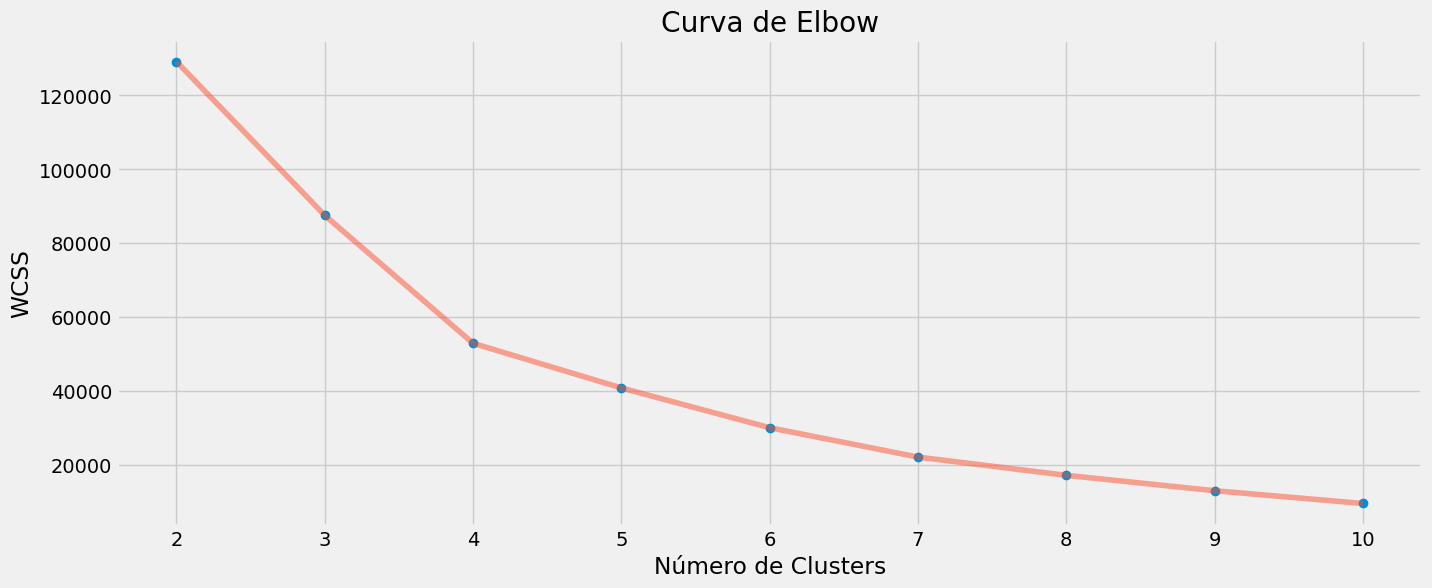

In [49]:
# Plot curva de Elbow

plt.figure(1, figsize=(15, 6))
plt.plot(np.arange(2,11), wcss_X1, 'o')
plt.plot(np.arange(2,11), wcss_X1, '-', alpha=0.5)
plt.xlabel('Número de Clusters'), plt.ylabel('WCSS')
plt.title("Curva de Elbow")
plt.show()

O gráfico acima é chamado de Curva de Elbow e normalmente usamos o valor com o menor WCSS.

#### Segmentação 1 - Construindo e Treinando o Modelo

In [51]:
# Criação do modelo

modelo_seg1 = KMeans(n_clusters=2,
                     init='k-means++',
                     max_iter=300,
                     tol=0.0001,
                     random_state=111,
                     algorithm='elkan')

# Treinamento do modelo
modelo_seg1.fit(X1)

c:\Users\moise\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(algorithm='elkan', n_clusters=2, random_state=111)

In [52]:
# Extração dos labels
labels1 = modelo_seg1.labels_
labels1

array([0, 0, 1, ..., 0, 0, 0])

In [53]:
# Extração dos centróides
centroids1 = modelo_seg1.cluster_centers_
centroids1

array([[0.881644  , 1.82183485],
       [3.79958153, 4.05580631]])

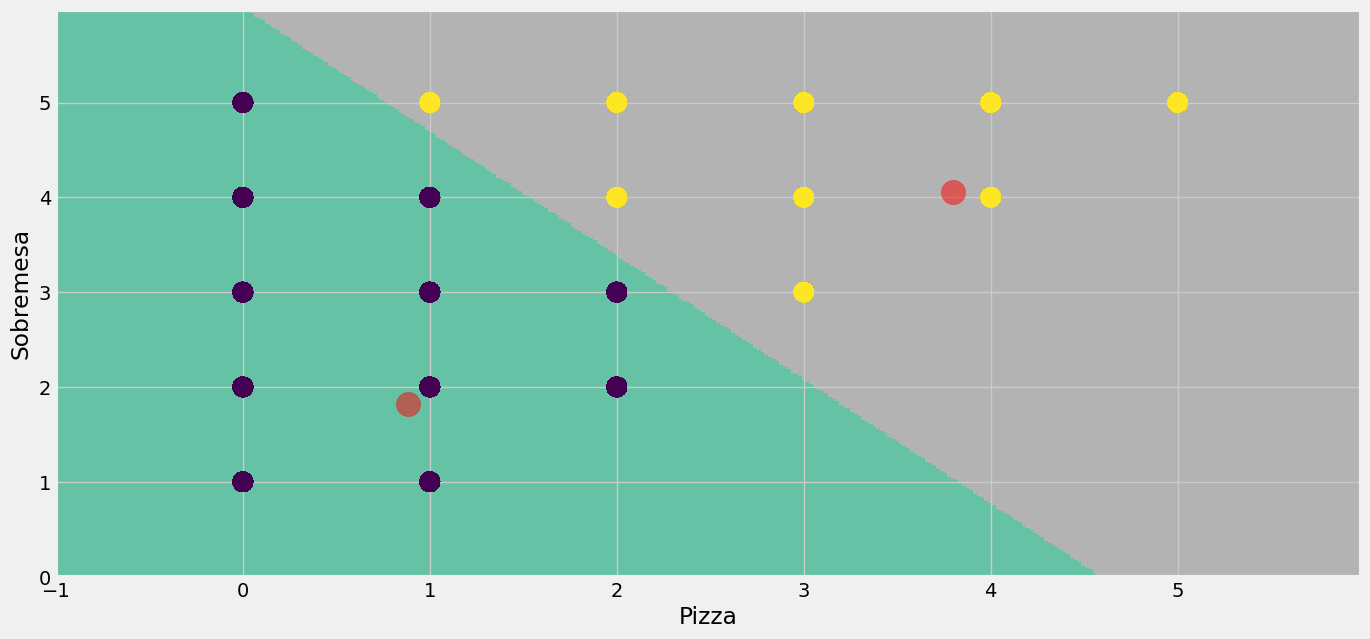

In [54]:
# Plot

# Parâmetros do Meshgrid
h = 0.02
x_min, x_max = X1[:,0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),  np.arange(y_min,y_max,h))
Z = modelo_seg1.predict(np.c_[xx.ravel(), yy.ravel()])
plt.figure(1, figsize=(15, 7))
plt.clf()
Z=Z.reshape(xx.shape)

# Plot da imagem
plt.imshow(Z,
           interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Set2,
           aspect='auto',
           origin='lower')

# Plot dos pontos de dados
plt.scatter(x='pizza', y='sobremesa', data = df, c = labels1, s=200)
plt.scatter(x = centroids1[:, 0], y = centroids1[:,1], s = 300, c = 'red', alpha = 0.5)
plt.xlabel('Pizza')
plt.ylabel('Sobremesa')
plt.show()

**Interpretação**: 

- O ponto vermelho é o centróide de cada cluster (segmento).


- No cluster 1 (área em verde) temos os clientes que pediram 0, 1 ou 2 Pizzas. Em todos os casos houve pedido de Sobremesa.


- No cluster 2 (área em cinza) estão clientes que pediram 2, 3, 4 ou 5 Pizzas. Percebe-se que à medida que o pedido tem maior número de Pizzas, também aumenta o número de Sobremesas.

**Análise**:

- Cluster 1 - Clientes que pedem menos Pizzas. Todos pedem sobremesa.

- Cluster 2 - Clientes que pedem mais Pizzas. Todos pedem sobremesa em volume maior.

Como estratégia de Marketing, poderíamos oferecer ao cliente uma sobremesa grátis no caso de comprar mais uma Pizza de maior valor.

----------------

Criando mais 4 Segmentações:

- Segmentação 2 - Variáveis Pizza e Salada
- Segmentação 3 - Variáveis Pizza e Localidade
- Segmentação 4 - Variáveis Pizza, Salada e Localidade
- Segmentação 5 - Variáveis Pizza, Salada e Sobremesa